# Model comparisons

In this notebook, we'll take BartPy through its paces using increasingly complex sin wave models.  We'll compare how it performs to two similar models: OLS and catboost.

For the purposes of this exercise, I'm testing out of the box performance.  This makes sense, as part of the value prop of BartPy is it's ability to work well without parameter tuning, but it's possible that the scores of all of the models could be improved with parameter tuning

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import catboost 
from catboost import Pool
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from copy import deepcopy

from bartpy.sklearnmodel import SklearnModel

%matplotlib inline

## Set up models

In [2]:
def fit_catboost(X_train, y_train, X_test, y_test):
    eval_cutoff = len(X_train) // 3
    eval_X, eval_y, train_X, train_y = X_train[:eval_cutoff, :], y_train[:eval_cutoff], X_train[eval_cutoff:, :], y_train[eval_cutoff:]
    catboost_model = catboost.CatBoostRegressor()
    catboost_model.fit(Pool(train_X, train_y), eval_set = Pool(eval_X, eval_y), use_best_model=True, verbose=300)
    pred = catboost_model.predict(X_test)
    score = r2_score(y_test, pred)
    return catboost_model, pred, score

def fit_bartpy(X_train, y_train, X_test, y_test):
    model = SklearnModel(n_samples=1000, 
                         n_burn=200, 
                         n_trees=200, 
                         n_chains=4,
                         n_jobs=-1,
                         store_in_sample_predictions=False)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    return model, pred, score

def fit_linear_model(X_train, y_train, X_test, y_test):
    rebased_x = np.sin(X_train[:, 0]).reshape(-1, 1)
    linear_model = LinearRegression()
    linear_model.fit(rebased_x, y_train)
    pred = linear_model.predict(np.sin(X_test[:, 0]).reshape(-1, 1))
    score = linear_model.score(np.sin(X_test[:, 0]).reshape(-1, 1), y_test)
    return linear_model, pred, score

kf = KFold(2)

def compare_models(X, y, models_funcs = [fit_bartpy, fit_catboost, fit_linear_model]):
    scores, predictions, trained_models, train_splits, test_splits = [], [], [], [], []

    for train_index, test_index in kf.split(X):
        trained_models.append([])    
        scores.append([])
        predictions.append([])
        train_splits.append(train_index)
        test_splits.append(test_index)

        for f in models_funcs:
            model, pred, score = f(X[train_index, :], y[train_index], X[test_index, :], y[test_index])
            trained_models[-1].append(deepcopy(model))
            predictions[-1].append(pred)
            scores[-1].append(score)
    return scores, predictions, trained_models, train_splits, test_splits

In [3]:
def plot_prediction_against_actual(y, predictions, test_splits):
    for p, test_index in zip(predictions, test_splits):
        for m in p:
            plt.scatter(y[test_index], m)
    plt.title("Preicted V Actual Per Model")
    plt.xlabel("True Target")
    plt.ylabel("Predicted Target")

def plot_covariate_against_prediction(X, predictions, test_splits, split_index, feature_index):
    test_index = test_splits[split_index]
    plt.scatter(X[test_index, feature_index],predictions[split_index][1], label="catboost")
    plt.scatter(X[test_index, feature_index],predictions[split_index][2], label="OLS")
    plt.scatter(X[test_index, feature_index],predictions[split_index][0], label="bartpy")
    plt.ylabel("Prediction")
    plt.xlabel("Covariate")
    plt.title("Prediction by model by value of X")
    plt.legend(loc="best")

## One dimensional, single wave

Text(0.5, 1.0, 'X v y')

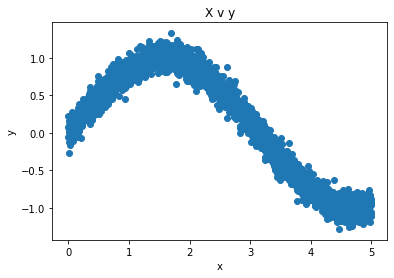

In [4]:
x = np.linspace(0, 5, 3000)
X = pd.DataFrame(x).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=3000) + np.sin(X[:, 0])
plt.scatter(X[:, 0], y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")

In [5]:
scores, predictions, models, train_splits, test_splits = compare_models(X, y)

Learning rate set to 0.046077
0:	learn: 0.6904949	test: 0.6880123	best: 0.6880123 (0)	total: 54.2ms	remaining: 54.1s
300:	learn: 0.0966597	test: 0.0981311	best: 0.0974514 (176)	total: 251ms	remaining: 583ms
600:	learn: 0.0931206	test: 0.1002908	best: 0.0974514 (176)	total: 445ms	remaining: 295ms
900:	learn: 0.0911902	test: 0.1023228	best: 0.0974514 (176)	total: 648ms	remaining: 71.2ms
999:	learn: 0.0907995	test: 0.1028430	best: 0.0974514 (176)	total: 712ms	remaining: 0us

bestTest = 0.09745144836
bestIteration = 176

Shrink model to first 177 iterations.
Learning rate set to 0.046077
0:	learn: 0.6885020	test: 0.6942689	best: 0.6942689 (0)	total: 1.35ms	remaining: 1.35s
300:	learn: 0.0950076	test: 0.0987536	best: 0.0979791 (166)	total: 194ms	remaining: 451ms
600:	learn: 0.0913979	test: 0.1007699	best: 0.0979791 (166)	total: 377ms	remaining: 250ms
900:	learn: 0.0893979	test: 0.1023758	best: 0.0979791 (166)	total: 561ms	remaining: 61.6ms
999:	learn: 0.0888951	test: 0.1028475	best: 0.09797

**As we might expect, all three models are capable of capturing such a simple function.  There's very little difference between the scores or predictions of the models.**

In [6]:
scores

[[0.9806128889621087, 0.9808769882368441, 0.9812104330040549],
 [0.9804238592192183, 0.9802956276780866, 0.9809006163120686]]

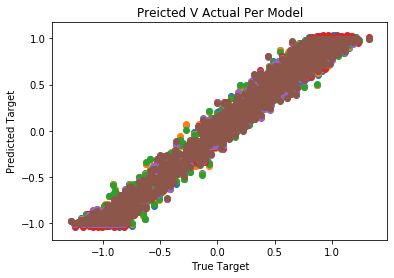

In [7]:
plot_prediction_against_actual(y, predictions, test_splits)

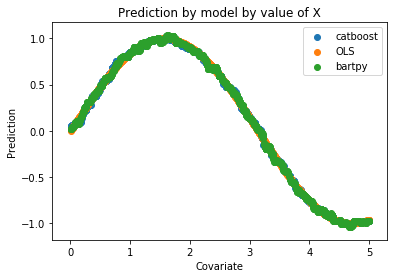

In [8]:
plot_covariate_against_prediction(X, predictions, test_splits, 1, 0)

## Single dimension - multiple waves

** To extend our original model, let's add a high frequency cosine wave in our single dimension.  This will make the predicted function change faster and at varying rates across x **

Text(0.5, 1.0, 'X v y')

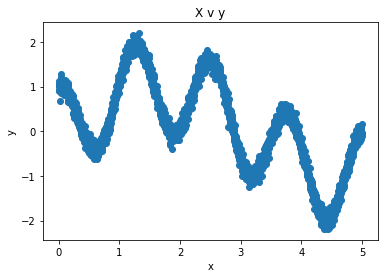

In [9]:
x = np.linspace(0, 5, 3000)
X = pd.DataFrame(x).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=3000) + np.sin(X[:, 0]) + np.cos(5 * X[:, 0])
plt.scatter(X[:, 0], y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")

In [10]:
scores, predictions, models, train_splits, test_splits = compare_models(X, y)

Learning rate set to 0.046077
0:	learn: 0.9934074	test: 0.9947985	best: 0.9947985 (0)	total: 1.62ms	remaining: 1.62s
300:	learn: 0.1006679	test: 0.1150237	best: 0.1150237 (300)	total: 203ms	remaining: 471ms
600:	learn: 0.0945074	test: 0.1140979	best: 0.1139724 (492)	total: 393ms	remaining: 261ms
900:	learn: 0.0922886	test: 0.1149004	best: 0.1139724 (492)	total: 588ms	remaining: 64.6ms
999:	learn: 0.0919235	test: 0.1150951	best: 0.1139724 (492)	total: 655ms	remaining: 0us

bestTest = 0.1139724327
bestIteration = 492

Shrink model to first 493 iterations.
Learning rate set to 0.046077
0:	learn: 0.9647855	test: 0.9523732	best: 0.9523732 (0)	total: 1.35ms	remaining: 1.35s
300:	learn: 0.1045856	test: 0.1114030	best: 0.1114030 (300)	total: 202ms	remaining: 469ms
600:	learn: 0.0982732	test: 0.1090977	best: 0.1089771 (539)	total: 398ms	remaining: 264ms
900:	learn: 0.0959376	test: 0.1090624	best: 0.1088563 (806)	total: 582ms	remaining: 64ms
999:	learn: 0.0954672	test: 0.1091444	best: 0.1088563 

** Catboost and BartPy capture this faster moving sin wave pretty nicely, and come up with very similar predictions.  The linear model pretty much treats the cos wave as noise, and fits a curve close to the original one **

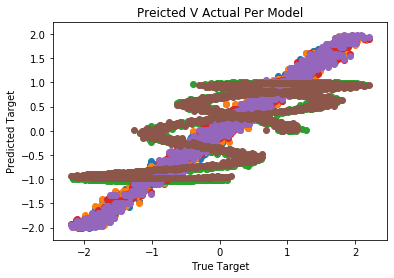

In [11]:
plot_prediction_against_actual(y, predictions, test_splits)

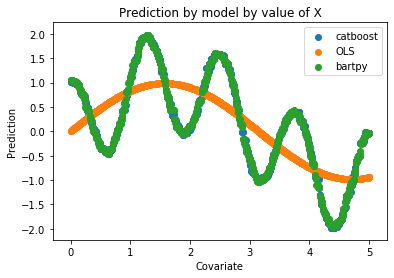

In [12]:
plot_covariate_against_prediction(X, predictions, test_splits, 1, 0)

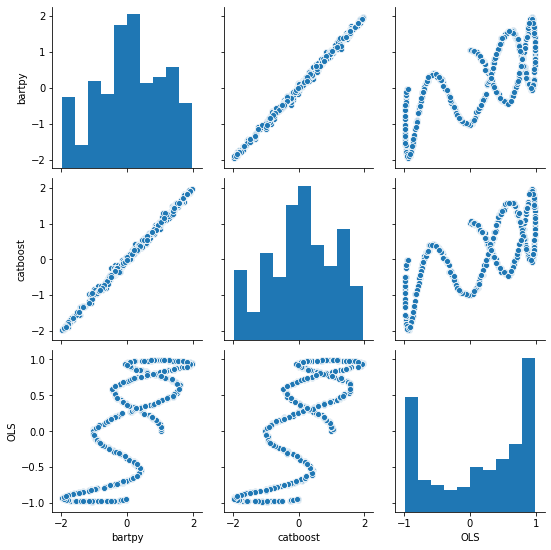

In [13]:
import seaborn as sns
p = pd.DataFrame(np.array(predictions[1]).T, columns = ["bartpy", "catboost", "OLS"])
sns.pairplot(p)

## Single dimension - discrete break points

** To make the model more complex, let's add some discrete dumps to make the curve less smooth.  This will test the ability of the models to handle very isolated effects in feature space **

Text(0.5, 1.0, 'X v y')

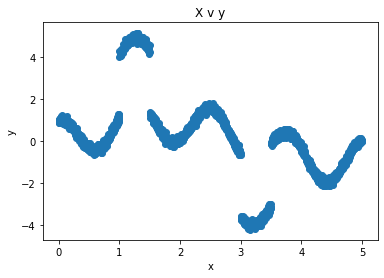

In [14]:
x = np.linspace(0, 5, 3000)
X = pd.DataFrame(x).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=3000) + np.sin(X[:, 0]) + np.cos(5 * X[:, 0])
y[(X[:,0] < 1.5) & (X[:,0] > 1.)] += 3
y[(X[:,0] < 3.5) & (X[:,0] > 3.)] -= 3
plt.scatter(X[:, 0], y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")

In [15]:
scores, predictions, models, train_splits, test_splits = compare_models(X, y)

Learning rate set to 0.046077
0:	learn: 2.0249057	test: 1.9762890	best: 1.9762890 (0)	total: 1.05ms	remaining: 1.05s
300:	learn: 0.1730722	test: 0.2784624	best: 0.2774811 (223)	total: 194ms	remaining: 450ms
600:	learn: 0.1581279	test: 0.2822762	best: 0.2774811 (223)	total: 376ms	remaining: 249ms
900:	learn: 0.1547546	test: 0.2853854	best: 0.2774811 (223)	total: 568ms	remaining: 62.4ms
999:	learn: 0.1542514	test: 0.2860638	best: 0.2774811 (223)	total: 630ms	remaining: 0us

bestTest = 0.2774811298
bestIteration = 223

Shrink model to first 224 iterations.
Learning rate set to 0.046077
0:	learn: 1.9675861	test: 1.9980471	best: 1.9980471 (0)	total: 987us	remaining: 986ms
300:	learn: 0.1880747	test: 0.2268492	best: 0.2268492 (300)	total: 192ms	remaining: 446ms
600:	learn: 0.1728099	test: 0.2186123	best: 0.2185730 (586)	total: 378ms	remaining: 251ms
900:	learn: 0.1703407	test: 0.2187935	best: 0.2184685 (770)	total: 562ms	remaining: 61.7ms
999:	learn: 0.1698324	test: 0.2190395	best: 0.2184685

In [16]:
scores

[[0.9922216264577248, 0.9870015668310034, 0.2951019225894349],
 [0.9940161555583875, 0.9889802037929508, 0.31764061177535946]]

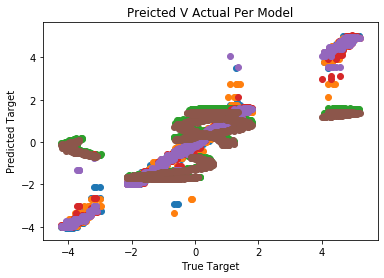

In [17]:
plot_prediction_against_actual(y, predictions, test_splits)

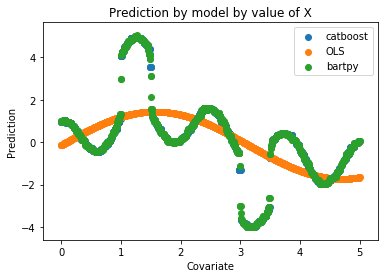

In [18]:
plot_covariate_against_prediction(X, predictions, test_splits, 1, 0)

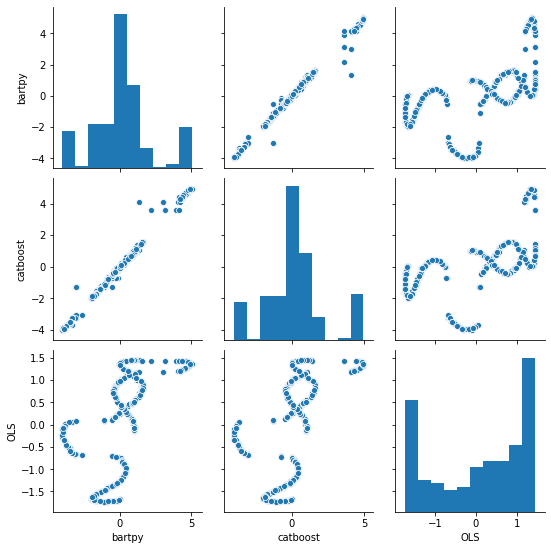

In [19]:
import seaborn as sns
p = pd.DataFrame(np.array(predictions[1]).T, columns = ["bartpy", "catboost", "OLS"])
sns.pairplot(p)

# Single meaningful dimension - additional noise dimensions

** It's important for the models to be able to correctly identify features that aren't important.  In this case, we just add normally distributed noise features.  This shouldn't be too difficult a problem to solve **

Text(0.5, 1.0, 'X v y')

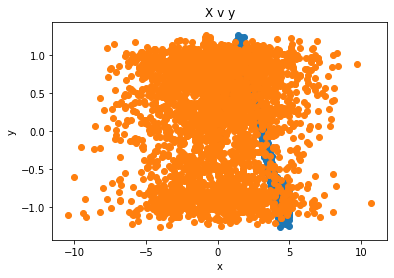

In [20]:
x = np.linspace(0, 5, 3000)
X = np.random.normal(0, 3, size = 3000 * 8).reshape(3000, 8)
X[:, 0] = x
X = pd.DataFrame(X).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=3000) + np.sin(X[:, 0])
plt.scatter(X[:, 0], y)
plt.scatter(X[:, 1], y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")

In [21]:
scores, predictions, models, train_splits, test_splits = compare_models(X, y)

Learning rate set to 0.046077
0:	learn: 0.7014599	test: 0.6909322	best: 0.6909322 (0)	total: 1.82ms	remaining: 1.82s
300:	learn: 0.0708725	test: 0.1092401	best: 0.1089265 (203)	total: 246ms	remaining: 572ms
600:	learn: 0.0496617	test: 0.1106342	best: 0.1089265 (203)	total: 485ms	remaining: 322ms
900:	learn: 0.0363843	test: 0.1111062	best: 0.1089265 (203)	total: 827ms	remaining: 90.8ms
999:	learn: 0.0331902	test: 0.1114189	best: 0.1089265 (203)	total: 933ms	remaining: 0us

bestTest = 0.1089264923
bestIteration = 203

Shrink model to first 204 iterations.
Learning rate set to 0.046077
0:	learn: 0.7022567	test: 0.6695192	best: 0.6695192 (0)	total: 1.93ms	remaining: 1.93s
300:	learn: 0.0702167	test: 0.1054306	best: 0.1038735 (165)	total: 246ms	remaining: 572ms
600:	learn: 0.0488468	test: 0.1082234	best: 0.1038735 (165)	total: 491ms	remaining: 326ms
900:	learn: 0.0349572	test: 0.1091821	best: 0.1038735 (165)	total: 757ms	remaining: 83.2ms
999:	learn: 0.0317149	test: 0.1094885	best: 0.103873

In [22]:
scores

[[0.9776670938368426, 0.9804054928680594, 0.9819510603353212],
 [0.9769423624072204, 0.9793968811773819, 0.9811971722649624]]

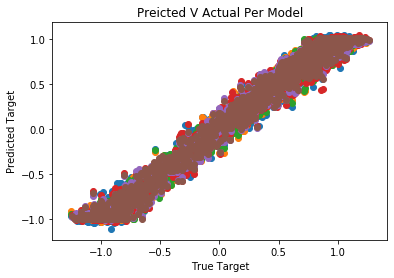

In [23]:
plot_prediction_against_actual(y, predictions, test_splits)

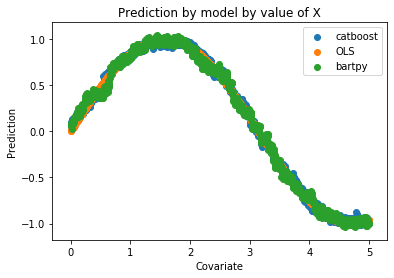

In [24]:
plot_covariate_against_prediction(X, predictions, test_splits, 1, 0)

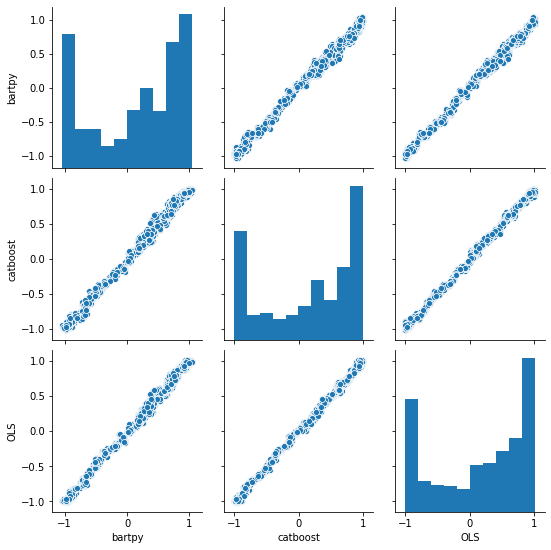

In [25]:
import seaborn as sns
p = pd.DataFrame(np.array(predictions[1]).T, columns = ["bartpy", "catboost", "OLS"])
sns.pairplot(p)

## Mixture of multiple meaningful dimensions and noise dimensions

** Both catboost and BartPy have performed well with noise dimensions and rapidly moving targets, let's combine them to make a relatively difficult test for tree models **

BartPy does significantly worse than catboost in this test.  It can't match the very rapidly moving cos wave, while catboost does an excellent job.

Text(0.5, 1.0, 'X v y')

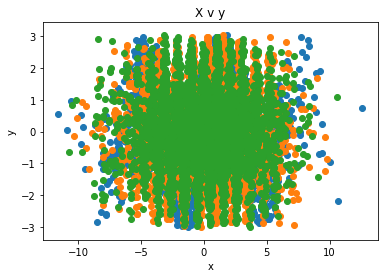

In [26]:
X = np.random.normal(0, 3, size = 3000 * 8).reshape(3000, 8)
X = pd.DataFrame(X).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=3000) + np.sin(X[:, 0]) + np.sin(5 * X[:, 1]) + np.cos(-6 * X[:, 3])
plt.scatter(X[:, 0], y)
plt.scatter(X[:, 1], y)
plt.scatter(X[:, 3], y)

plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")


In [27]:
scores, predictions, models, train_splits, test_splits = compare_models(X, y)

Learning rate set to 0.046077
0:	learn: 1.2071709	test: 1.2274656	best: 1.2274656 (0)	total: 1.26ms	remaining: 1.25s
300:	learn: 0.5214435	test: 0.8112397	best: 0.8112397 (300)	total: 249ms	remaining: 579ms
600:	learn: 0.2805957	test: 0.6565300	best: 0.6565300 (600)	total: 495ms	remaining: 329ms
900:	learn: 0.1768165	test: 0.6120706	best: 0.6120706 (900)	total: 744ms	remaining: 81.7ms
999:	learn: 0.1542937	test: 0.6026805	best: 0.6026437 (998)	total: 825ms	remaining: 0us

bestTest = 0.602643672
bestIteration = 998

Shrink model to first 999 iterations.
Learning rate set to 0.046077
0:	learn: 1.2175917	test: 1.2833024	best: 1.2833024 (0)	total: 2.05ms	remaining: 2.04s
300:	learn: 0.5196479	test: 0.8241700	best: 0.8241700 (300)	total: 252ms	remaining: 585ms
600:	learn: 0.2896781	test: 0.6666183	best: 0.6666183 (600)	total: 494ms	remaining: 328ms
900:	learn: 0.1809154	test: 0.6023277	best: 0.6023277 (900)	total: 767ms	remaining: 84.3ms
999:	learn: 0.1575576	test: 0.5926307	best: 0.5926307

In [28]:
scores

[[0.4474648128069827, 0.776096900193399, 0.32349435338659893],
 [0.4729599336660458, 0.7971621384928165, 0.3404468586098318]]

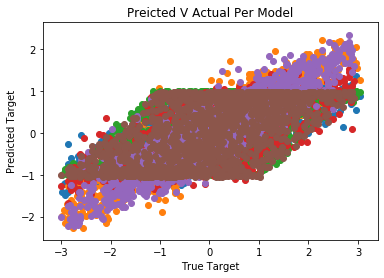

In [29]:
plot_prediction_against_actual(y, predictions, test_splits)

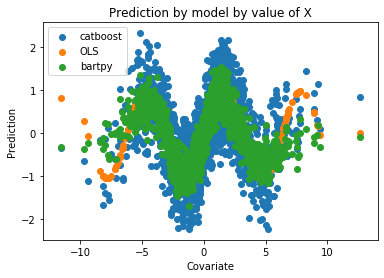

In [30]:
plot_covariate_against_prediction(X, predictions, test_splits, 1, 0)

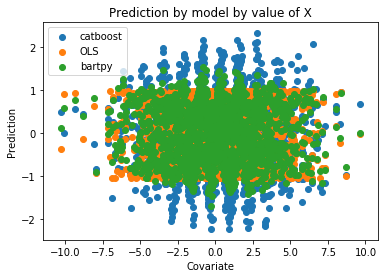

In [31]:
plot_covariate_against_prediction(X, predictions, test_splits, 1, 1)

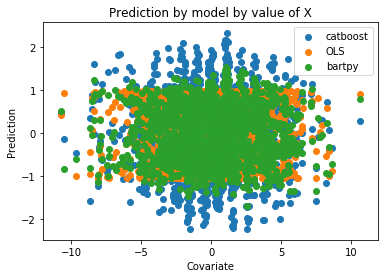

In [32]:
plot_covariate_against_prediction(X, predictions, test_splits, 1, 3)